In [1]:
import random, copy, os
from joblib import Parallel, delayed

import numpy as np
# from numba import jit
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from PointSystem import PointSystem

from perlin_noise import PerlinNoise

In [25]:
N = 2       # размерность системы
M = 10    # число точек

noise_generator = PerlinNoise(octaves=2, seed=1)
# ng = lambda point: noise_generator(point) * 3 + 2
ng = lambda point: noise_generator(point) * 10 + 6

In [26]:
import plotly.graph_objects as go
n, m = 100, 100
# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
noise = [[ng([i/n, j/n]) for j in range(n)] for i in range(n)]

fig = go.Figure(data=[
    go.Surface(z=noise)
    ])
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

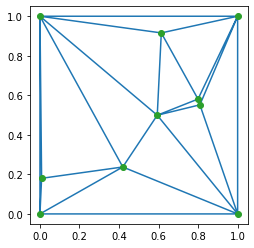

(None, 0.36666666666666664)

In [27]:
ps = PointSystem(M, N)
# x, y = points.T
# plt.scatter(x,y)
# plt.show()
tri = ps.triangulation
points = ps.points
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show(), ps.evaluate(ng)

In [28]:
def evalObject(object, f: callable) -> tuple[any, float]:
    return (object, object.evaluate(f))

def evalObjectList(objectList: list[any], f: callable) -> list[tuple[any, float]]:
    return Parallel(n_jobs=os.cpu_count())(delayed(evalObject)(object, f) for object in objectList)

def mutateXevalObject(object, f: callable) -> tuple[any, float]:
    object.Mutate()
    return (object, object.evaluate(f))

def mutateXevalObjectList(objectList: list[any], f: callable) -> list[tuple[any, float]]:
    return Parallel(n_jobs=os.cpu_count())(delayed(mutateXevalObject)(object, f) for object in objectList)

def generatePopulation(objectGenerator: callable, population_size: int = 100) -> list:
    return [objectGenerator() for _ in range(population_size)]

# @jit
def training(f: callable, population: list, epochs: int = 100):
    
    population_size = len(population)
    # генерируем популяцию
    objects = evalObjectList(population, f)
    objects.sort(key=lambda d: d[1], reverse=True)
    evaluations = [d[1] for d in objects]
    plt.plot(evaluations, color='black', label='#')

    # "обучаем"
    for epoch in range(epochs):
        
        _objects: list[PointSystem] = list()
        
        while len(_objects) < population_size:
            i = random.choice(range(population_size))
            # prob = np.exp(-np.pi*(i/population_size)+1)
            # prob = 1/(np.pi*np.pi*np.pi*(i/population_size+0.001))
            # prob = -np.log(i/population_size)
            x = i / population_size
            prob = np.exp(-(np.pi*x)**2)#+np.power(10, x)
            if random.random() < prob:
                _objects.append(copy.deepcopy(objects[i][0]))
        
        objects = mutateXevalObjectList(_objects, f)
        objects.sort(key=lambda d: d[1], reverse=True)
        evaluations = [d[1] for d in objects]
        plt.plot(evaluations, label=f'#{epoch}')
        if evaluations[0] >= 1:
            break
    
    print(f'лучший результат: {evaluations[0]}')
    # plt.legend()
    plt.show()
    
    return [d[0] for d in objects]

лучший результат: 1.0


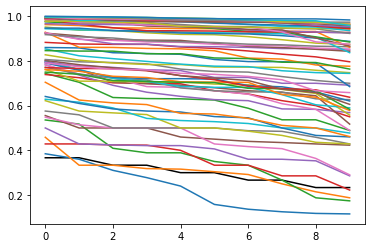

In [30]:
res = training(ng, generatePopulation(lambda: PointSystem(M, N), 10), 100)

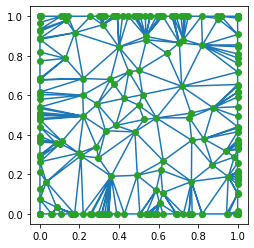

(None, 1.0, 0.24784991411600413, 221, 544, 544.0)

In [31]:
ps = res[0]
tri = ps.triangulation
points = ps.points
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show(), ps.evaluate(ng), ps.characteristic_distance, ps.M, len(ps.edges), len(ps.edges) * ps.evaluate(ng)

In [26]:
# @jit
def training(M: int, N: int, population_size: int = 100, epochs: int = 100):
    
    # генерируем популяцию
    PSs: list[PointSystem] = list()
    Es: list[float] = list()
    for _ in range(population_size):
        ps = PointSystem(M, N)
        e = ps.evaluate(ng)
        PSs.append((ps, e))
        Es.append(e)
    PSs.sort(key=lambda d: d[1], reverse=True)
    Es.sort(reverse=True)
    plt.plot(Es, color='black', label='#')

    # "обучаем"
    for epoch in range(epochs):
        newPSs: list[PointSystem] = list()
        newEs: list[float] = list()
        while len(newPSs) < population_size:
            i = random.choice(range(population_size))
            # prob = np.exp(-np.pi*(i/population_size)+1)
            # prob = 1/(np.pi*np.pi*np.pi*(i/population_size+0.001))
            # prob = -np.log(i/population_size)
            prob = np.exp(-(np.pi*i)**2/population_size**2)
            if random.random() < prob:
                newPS = copy.deepcopy(PSs[i][0])
                newPS.Mutate()
                e = newPS.evaluate(ng)
                newPSs.append((newPS, e))
                newEs.append(e)
        newPSs.sort(key=lambda d: d[1], reverse=True)
        newEs.sort(reverse=True)
        plt.plot(newEs, label=f'#{epoch}')
        PSs = newPSs
        Es = newEs
    
    print(f'лучший результат: {Es[0]}')
    plt.legend()
    plt.show()

In [ ]:
training(M, N, 100, 10)